<a href="https://colab.research.google.com/github/kangyans/d2l/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1,6, kernel_size = 5, padding = 2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6,16,kernel_size = 5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size =2, stride = 2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [ ]:
X = torch.rand(size=(1,1,28,28), dtype= torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'ouput shape: \t', X.shape)

In [11]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 16922436.29it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302955.49it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5489146.71it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19487614.61it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
      net.eval()
      if not device:
        device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)
  with torch.no_grad():
      for X, y in data_iter:
        if isinstance(X, list):
          X = [x.to(device) for x in X]
      else:
          X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X),y), y.numel())
  return metric[0]/metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):

      def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
          nn.init.xavier_uniform_(m.weight)

      net.apply(init_weights)
      print('training on', device)
      net.to(device)
      optimizer = torch.optim.SGD(net.parameters(), lr = lr)
      loss = nn.CrossEntropyLoss()
      animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
      timer, num_batches = d2l.Timer(), len(train_iter)
      for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X,y) in enumerate(train_iter):
          timer.start()
          optimizer.zero_grad()
          X,y   = X.to(device), y.to(device)
          y_hat = net(X)
          l = loss(y_hat,y)
          l.backward()
          optimizer.step()
          with torch.no_grad():
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
          timer.stop()
          train_l   = metric[0]/metric[2]
          train_acc = metric[1]/metric[2]
          if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
      print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
            f'test acc {test_acc:.3f}')
      print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
            f' on {str(device)}')


loss 0.471, train acc 0.823,test acc 0.875


ValueError: Invalid format specifier

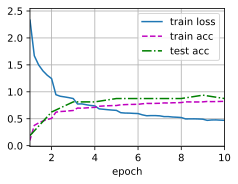

In [21]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())